In [1]:
PARETO_METHOD = "robust" 

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import math

# --- Configuration ---
CSV_FILE = "v3_experiment_results.csv"
IMG_DIR = "plots/samples/GMM"


# --- 1. Load Data ---
if not os.path.exists(CSV_FILE):
    raise FileNotFoundError(f"Error: {CSV_FILE} not found.")

df = pd.read_csv(CSV_FILE)

# Filter for 'best_loss' only
if 'TYPE' in df.columns:
    df = df[df['TYPE'] == 'best_loss']
    
if df.empty:
    raise ValueError("No 'best_loss' entries found in results.")

# --- 2. Prepare Metrics ---
# Minimize Error (1 - Acc) and Minimize Loss
df['val_error_mean'] = 1.0 - df['val_acc_mean']
df['val_error_ci'] = df['val_acc_ci']

# --- 3. Pareto Logic Switch ---
if PARETO_METHOD == "robust":
    print(">> Using ROBUST Pareto (Accounting for CI overlap)")
    # Dominator (Q) uses Worst Case (Mean + CI)
    df['compare_loss_dom'] = df['val_loss_mean'] + df['val_loss_ci']
    df['compare_error_dom'] = df['val_error_mean'] + df['val_error_ci']
    # Victim (P) uses Best Case (Mean - CI)
    df['compare_loss_vic'] = df['val_loss_mean'] - df['val_loss_ci']
    df['compare_error_vic'] = df['val_error_mean'] - df['val_error_ci']
    
else:
    print(">> Using STANDARD Pareto (Mean values only)")
    # Both use Mean
    df['compare_loss_dom'] = df['val_loss_mean']
    df['compare_error_dom'] = df['val_error_mean']
    df['compare_loss_vic'] = df['val_loss_mean']
    df['compare_error_vic'] = df['val_error_mean']

def calculate_pareto_mask(df):
    """
    Returns True if a model is NOT dominated.
    Dominance: Q dominates P if Q_dom is better than P_vic in ALL metrics.
    """
    n = len(df)
    # Broadcasting (all vs all)
    # Q (Dominator) -> (n, 1)
    q_loss = df['compare_loss_dom'].values[:, np.newaxis]
    q_error = df['compare_error_dom'].values[:, np.newaxis]
    
    # P (Victim) -> (1, n)
    p_loss = df['compare_loss_vic'].values[np.newaxis, :]
    p_error = df['compare_error_vic'].values[np.newaxis, :]
    
    # Check dominance (We want to minimize, so Lower is Better)
    # If standard: Q < P
    # If robust:   Q_worst < P_best
    dominates = (q_loss < p_loss) & (q_error < p_error)
    
    # A point is dominated if ANY row dominates it
    is_dominated = np.any(dominates, axis=0) 
    
    return ~is_dominated

# Apply Mask
df['is_pareto'] = calculate_pareto_mask(df)
pareto_df = df[df['is_pareto']].copy().sort_values(by='val_loss_mean')

print(f"Total Models: {len(df)}")
print(f"Pareto Optimal Models: {len(pareto_df)}")

>> Using ROBUST Pareto (Accounting for CI overlap)
Total Models: 27
Pareto Optimal Models: 6


In [3]:
# --- Helper to format "Mean ± CI" ---
def format_row(row):
    return pd.Series({
        'Val Loss': f"{row['val_loss_mean']:.4f} ± {row['val_loss_ci']:.4f}",
        'Val Acc': f"{row['val_acc_mean']:.4f} ± {row['val_acc_ci']:.4f}",
        'Test Loss': f"{row['test_loss_mean']:.4f} ± {row['test_loss_ci']:.4f}",
        'Test Acc': f"{row['test_acc_mean']:.4f} ± {row['test_acc_ci']:.4f}"
    })

# Select metadata columns
meta_cols = ['MODEL', 'SCALE', 'OPTIMIZER', 'TRANSFORM', 'DROPOUT']

# Create display table
display_df = pareto_df[meta_cols].join(pareto_df.apply(format_row, axis=1))

print("\n" + "="*80)
print("ROBUST PARETO OPTIMAL MODELS")
print("="*80)

# Print nice table
try:
    print(display_df.to_markdown(index=False))
except ImportError:
    print(display_df.to_string(index=False))

# Optional: Save to CSV
display_df.to_csv("pareto_summary_table.csv", index=False)


ROBUST PARETO OPTIMAL MODELS
| MODEL         |   SCALE | OPTIMIZER   |   TRANSFORM |   DROPOUT | Val Loss             | Val Acc         | Test Loss           | Test Acc        |
|:--------------|--------:|:------------|------------:|----------:|:---------------------|:----------------|:--------------------|:----------------|
| hybrid_v3_1x1 |       1 | Adam        |        0.25 |       0.1 | -2373.4716 ± 0.0486  | 0.9914 ± 0.0001 | -2362.8939 ± 0.0507 | 0.9928 ± 0.0001 |
| hybrid_v3_1x1 |       1 | Adam        |        0.5  |       0.1 | -2368.7248 ± 0.0400  | 0.9926 ± 0.0001 | -2357.4523 ± 0.0521 | 0.9932 ± 0.0001 |
| hybrid_v3_1x1 |       2 | Adam        |        0.5  |       0.1 | -2311.0138 ± 0.2131  | 0.9930 ± 0.0001 | -2302.0751 ± 0.2254 | 0.9944 ± 0.0001 |
| hybrid_v3_1x1 |       2 | Adam        |        0.5  |       0.2 | -2236.5436 ± 0.2086  | 0.9928 ± 0.0001 | -2226.8588 ± 0.1746 | 0.9941 ± 0.0001 |
| hybrid_v3_1x1 |       3 | Adam        |        0.5  |       0.1 | -2234.47

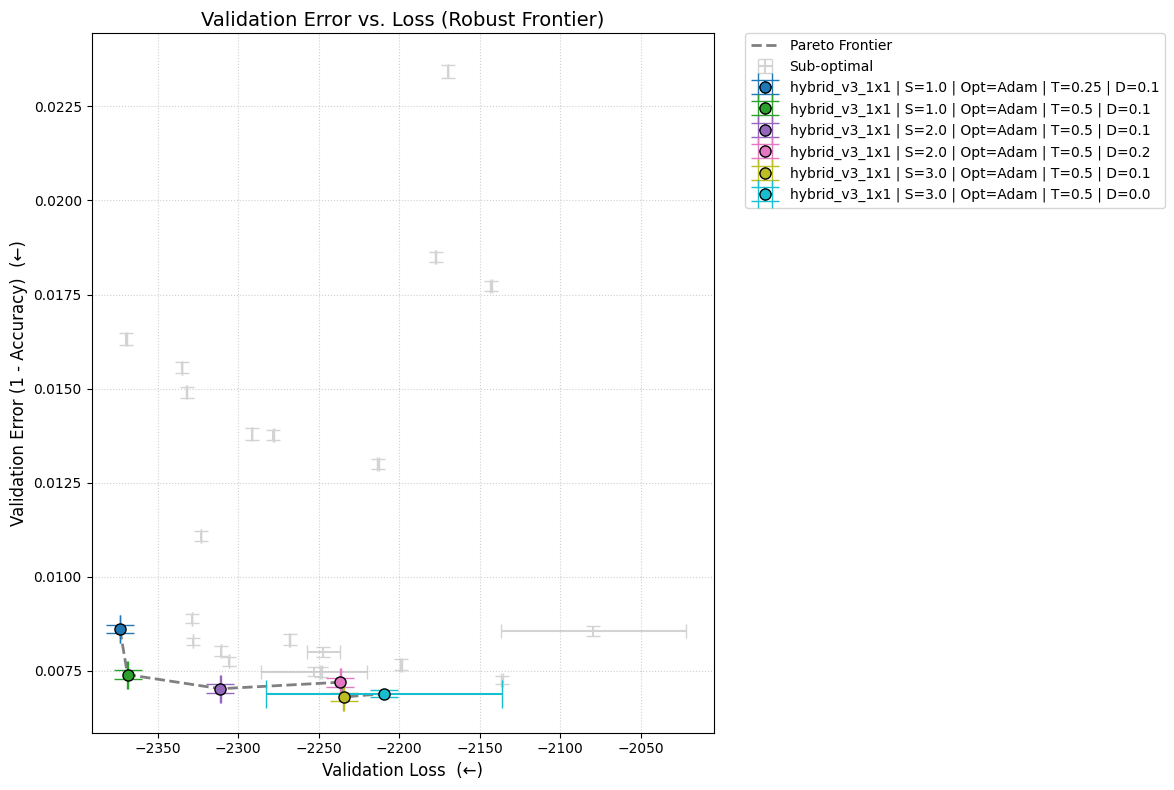

In [ ]:
plt.figure(figsize=(12, 8))

# 1. Plot Sub-optimal points
non_pareto = df[~df['is_pareto']]
plt.errorbar(
    x=non_pareto['val_loss_mean'], 
    y=non_pareto['val_error_mean'], 
    xerr=non_pareto['val_loss_ci'], 
    yerr=non_pareto['val_error_ci'], 
    fmt='none', color='lightgray', ecolor='lightgray', 
    capsize=5, label='Sub-optimal', zorder=1
)

# 2. Plot Pareto points
colors = plt.cm.tab10(np.linspace(0, 1, len(pareto_df)))

for (idx, row), color in zip(pareto_df.iterrows(), colors):
    label = (f"{row['MODEL']} | S={row['SCALE']} | "
             f"Opt={row['OPTIMIZER']} | T={row['TRANSFORM']} | D={row['DROPOUT']}")
    plt.errorbar(
        x=row['val_loss_mean'], 
        y=row['val_error_mean'], 
        xerr=row['val_loss_ci'], 
        yerr=row['val_error_ci'],
        fmt='o', color=color, ecolor=color, 
        capsize=10, markeredgecolor='black', markersize=8,
        label=label, zorder=5
    )

# 3. Draw Pareto frontier as dashed line
pareto_sorted = pareto_df.sort_values('val_loss_mean')
plt.plot(
    pareto_sorted['val_loss_mean'],
    pareto_sorted['val_error_mean'],
    linestyle='--', color='gray', linewidth=2, label='Pareto Frontier', zorder=4
)

plt.title(f'Validation Error vs. Loss ({PARETO_METHOD.capitalize()} Frontier)', fontsize=14)
plt.xlabel('Validation Loss  (←)', fontsize=12)
plt.ylabel('Validation Error (1 - Accuracy)  (←)', fontsize=12)
plt.grid(True, linestyle=':', alpha=0.6)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

plt.tight_layout()
plt.show()

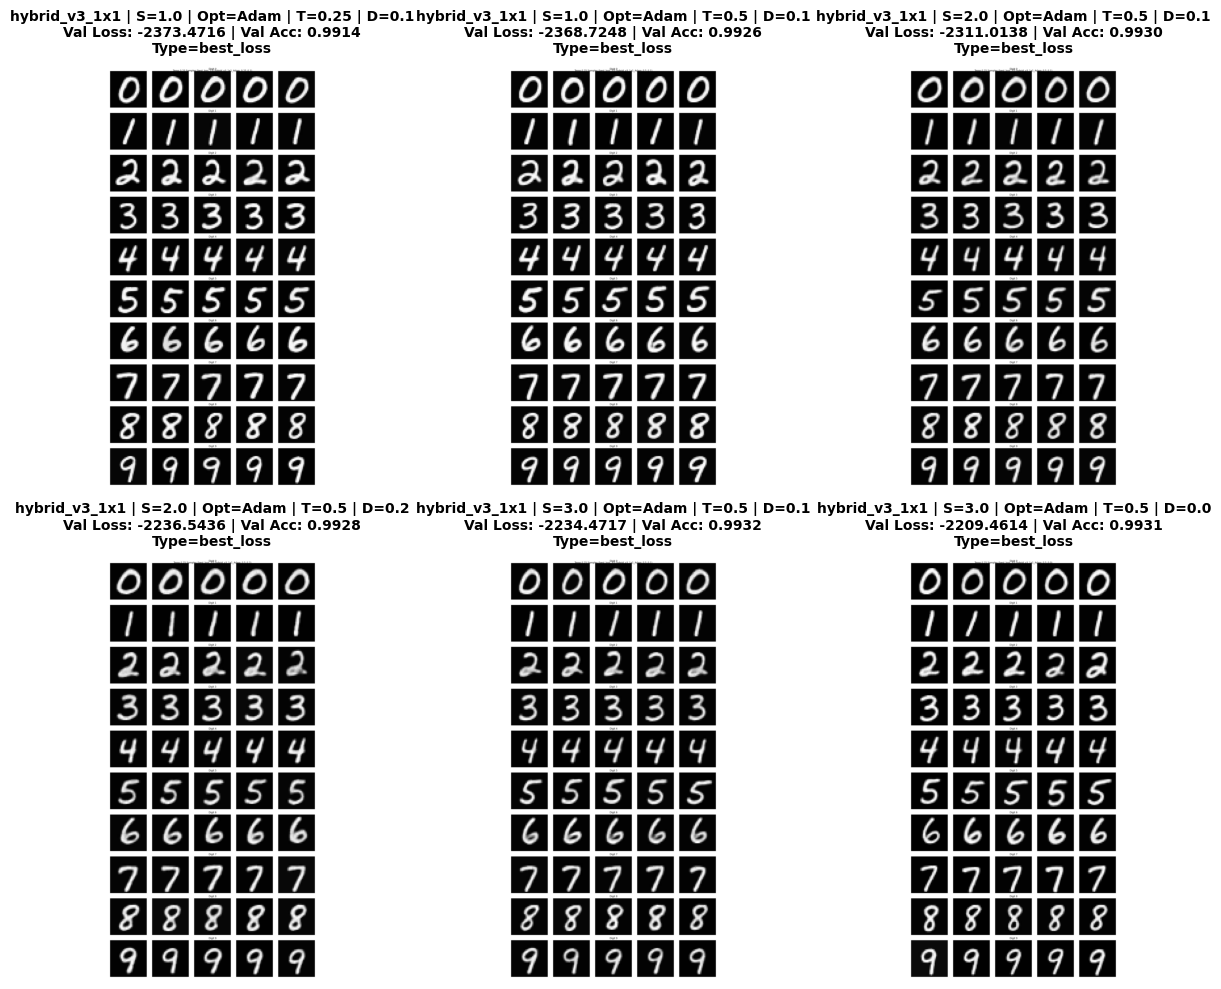

In [ ]:
# Grid settings
cols = 3
num_models = len(pareto_df)
rows = math.ceil(num_models / cols)

plt.figure(figsize=(4.5 * cols, 5 * rows))

for idx, (i, row) in enumerate(pareto_df.iterrows()):
    # Reconstruct ID to find the image file
    config_id = f"{row['TYPE']}_{row['SCALE']}_{row['MODEL']}_{row['OPTIMIZER']}_{row['TRANSFORM']}_{row['DROPOUT']}"
    img_path = f"{IMG_DIR}/{config_id}_samples.png"
    
    ax = plt.subplot(rows, cols, idx + 1)
    
    if os.path.exists(img_path):
        img = mpimg.imread(img_path)
        ax.imshow(img)
        title = (f"{row['MODEL']} | S={row['SCALE']} | "
                 f"Opt={row['OPTIMIZER']} | T={row['TRANSFORM']} | D={row['DROPOUT']}\n"
                 f"Val Loss: {row['val_loss_mean']:.4f} | Val Acc: {row['val_acc_mean']:.4f}\n"
                 f"Type={row['TYPE']}")
        ax.set_title(title, fontsize=10, fontweight='bold')
    else:
        ax.text(0.5, 0.5, f"Image not found:\n{config_id}", 
                ha='center', va='center', color='red')
        
    ax.axis('off')

plt.tight_layout()
plt.show()

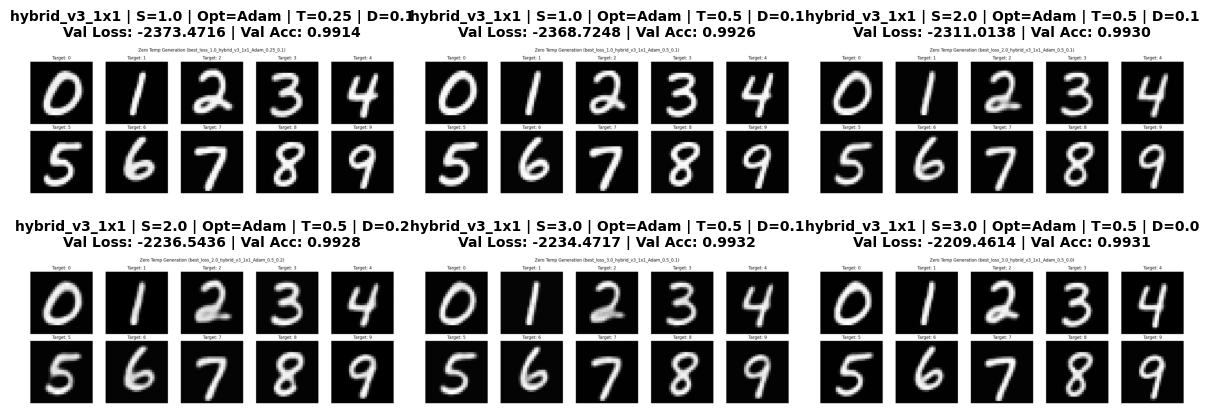

In [ ]:
# Grid settings
cols = 3
num_models = len(pareto_df)
rows = math.ceil(num_models / cols)

plt.figure(figsize=(4 * cols, 2.3 * rows))

for idx, (i, row) in enumerate(pareto_df.iterrows()):
    # Reconstruct ID to find the image file
    config_id = f"{row['TYPE']}_{row['SCALE']}_{row['MODEL']}_{row['OPTIMIZER']}_{row['TRANSFORM']}_{row['DROPOUT']}"
    img_path = f"{IMG_DIR}/{config_id}_zero_temp.png"
    
    ax = plt.subplot(rows, cols, idx + 1)
    
    if os.path.exists(img_path):
        img = mpimg.imread(img_path)
        ax.imshow(img)
        title = (f"{row['MODEL']} | S={row['SCALE']} | "
                 f"Opt={row['OPTIMIZER']} | T={row['TRANSFORM']} | D={row['DROPOUT']}\n"
                 f"Val Loss: {row['val_loss_mean']:.4f} | Val Acc: {row['val_acc_mean']:.4f}")
        ax.set_title(title, fontsize=10, fontweight='bold')
    else:
        ax.text(0.5, 0.5, f"Image not found:\n{config_id}", 
                ha='center', va='center', color='red')
        
    ax.axis('off')

plt.tight_layout()
plt.show()

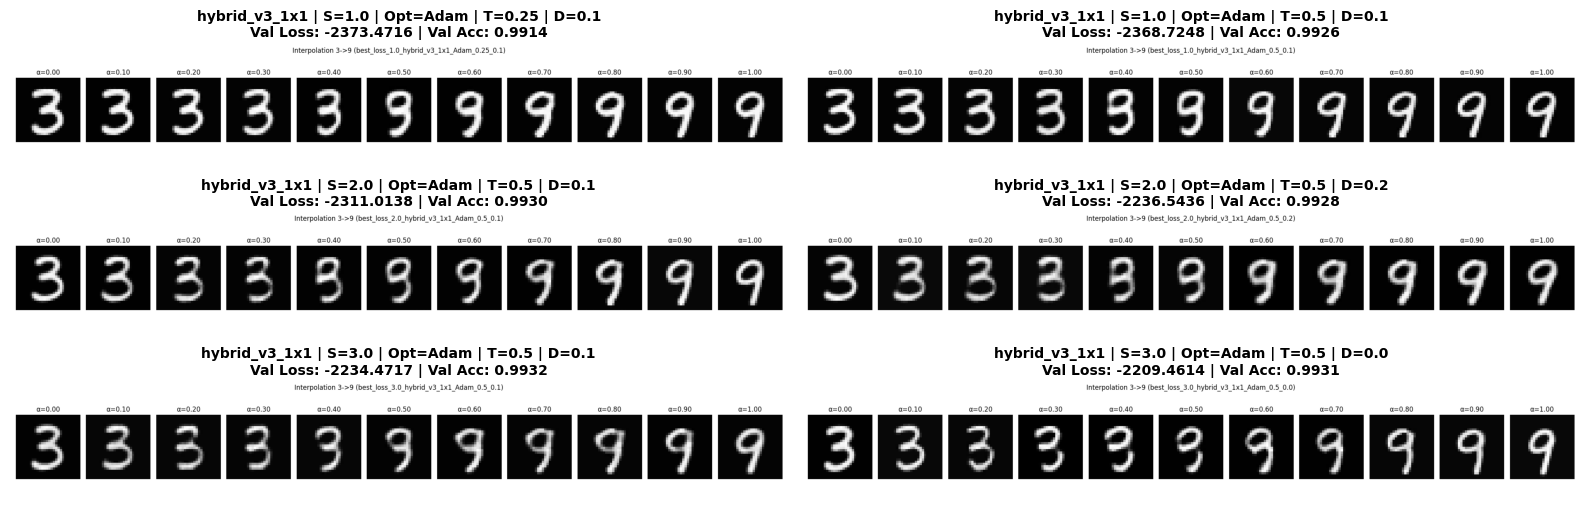

In [ ]:
# Grid settings
cols = 2
num_models = len(pareto_df)
rows = math.ceil(num_models / cols)

plt.figure(figsize=(8 * cols, 1.8 * rows))

for idx, (i, row) in enumerate(pareto_df.iterrows()):
    # Reconstruct ID to find the image file
    config_id = f"{row['TYPE']}_{row['SCALE']}_{row['MODEL']}_{row['OPTIMIZER']}_{row['TRANSFORM']}_{row['DROPOUT']}"
    img_path = f"{IMG_DIR}/{config_id}_interp.png"
    
    ax = plt.subplot(rows, cols, idx + 1)
    
    if os.path.exists(img_path):
        img = mpimg.imread(img_path)
        ax.imshow(img)
        title = (f"{row['MODEL']} | S={row['SCALE']} | "
                 f"Opt={row['OPTIMIZER']} | T={row['TRANSFORM']} | D={row['DROPOUT']}\n"
                 f"Val Loss: {row['val_loss_mean']:.4f} | Val Acc: {row['val_acc_mean']:.4f}")
        ax.set_title(title, fontsize=10, fontweight='bold')
    else:
        ax.text(0.5, 0.5, f"Image not found:\n{config_id}", 
                ha='center', va='center', color='red')
        
    ax.axis('off')

plt.tight_layout()
plt.show()